# Spaceship Titanic

Train dataframe description:
- **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination** - The planet the passenger will be debarking to.
- **Age** - The age of the passenger.
- **VIP** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name** - The first and last names of the passenger.
- **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [39]:
# Some modules that we are going to use.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, LearningCurveDisplay
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier

## Define Train and Test dataframe

In [40]:
# Define train and test dataframe.
train_df = pd.read_csv("../inputdata/train.csv", sep=",")
test_df = pd.read_csv("../inputdata/test.csv", sep=",")

print("Train_df shape:", train_df.shape)
print(train_df.describe())

print("\n\nFirst 10 samples:")
print(train_df.head(10))

Train_df shape: (8693, 14)
               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000  


First 10 samples:
  PassengerId HomePlanet CryoSleep  Cabin    Destina

## Explore the dataframes

### Missing values

In [41]:
print("Train missing values:")
print(train_df.isna().sum())

print("\n\nTest missing values:")
print(test_df.isna().sum())

Train missing values:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


Test missing values:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


### Print distributions

In [42]:
# Print distribution split by transported.
def distrib_split_by_transported(df, col_name):
    # Split into transported/not transported 
    not_tran= df[df["Transported"] == 0][col_name].dropna()
    tran = df[df["Transported"] == 1][col_name].dropna()
    
    # Create a stacked histogram
    plt.figure(figsize=(10, 6))
    plt.hist([not_tran, tran], bins=30, stacked=True, color=['blue', 'orange'], label=['Not transported', "Transported"], edgecolor='black')
    
    # Add labels and title
    plt.xlabel(col_name)
    plt.ylabel("Count")
    plt.title(f"{col_name} Distribution Split by Transported")
    plt.legend()
    plt.show()

['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']


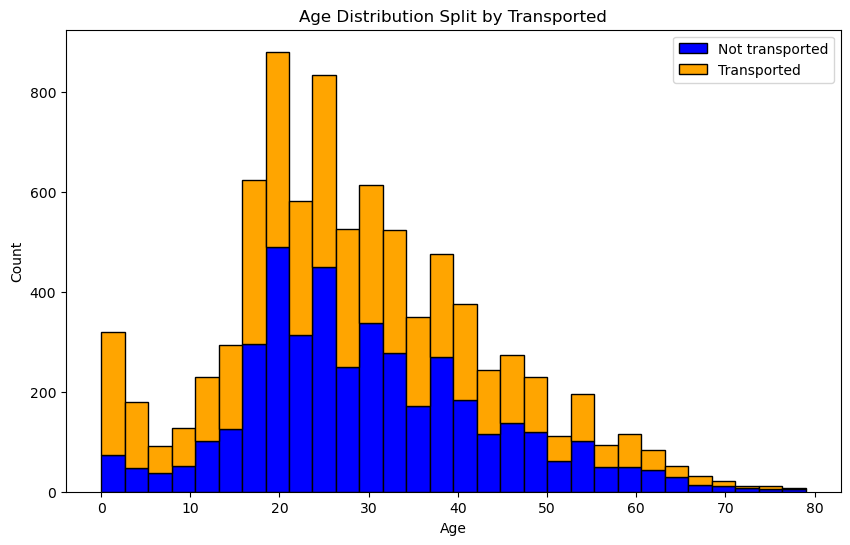

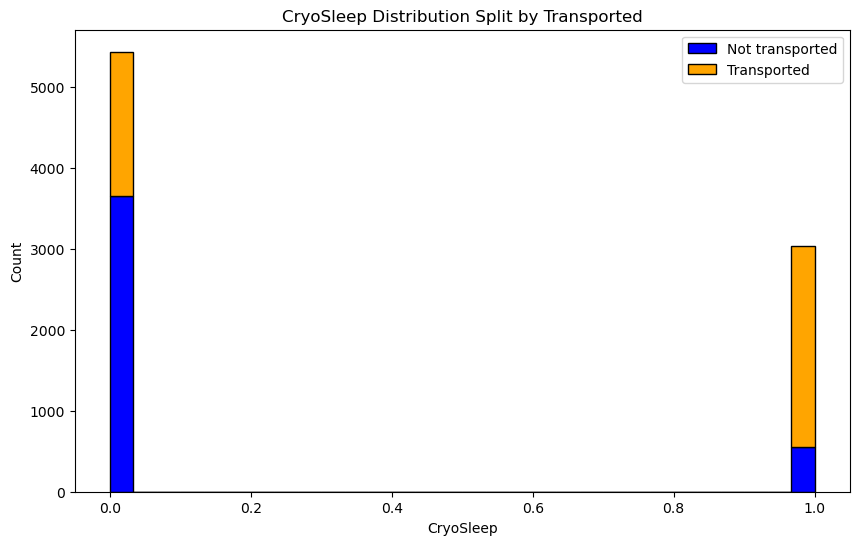

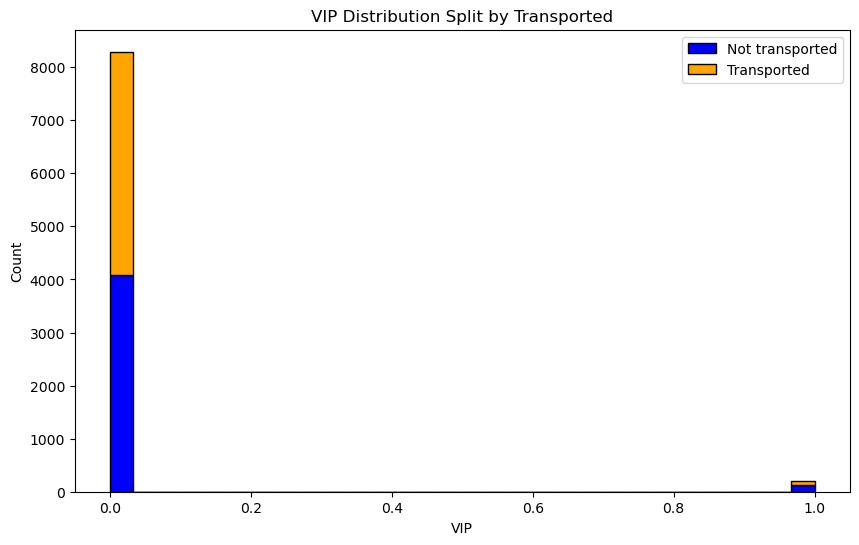

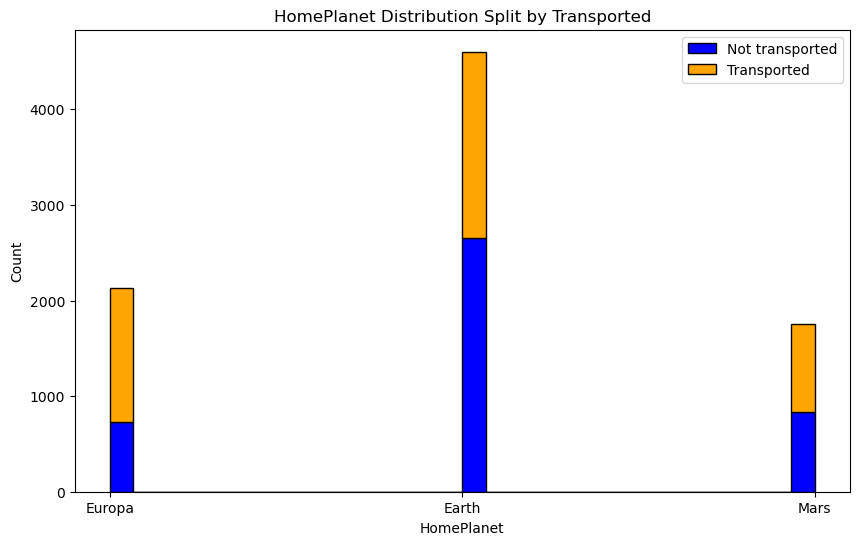

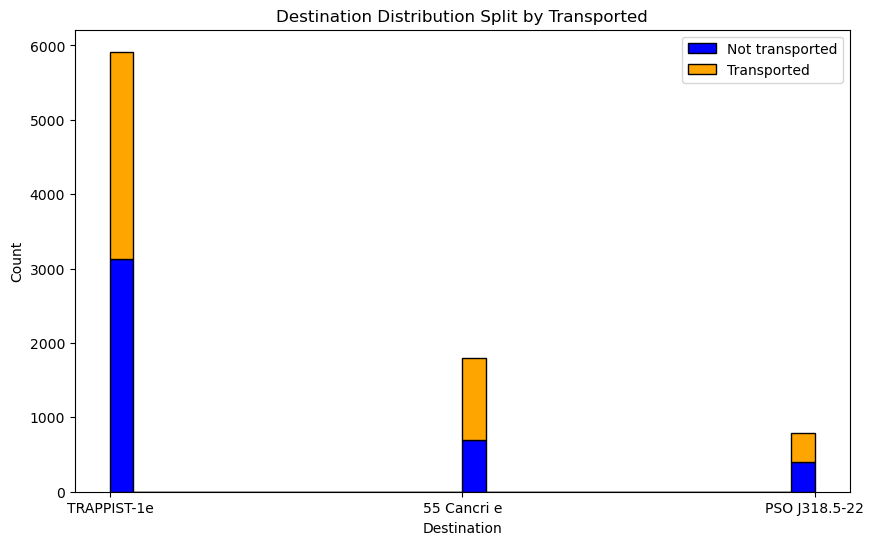

In [43]:
feature_names = list(train_df.columns)
print(feature_names)
for name in ["Age", "CryoSleep", "VIP", "HomePlanet", "Destination"]:
    distrib_split_by_transported(train_df, name)

### New feature: TotBill = RoomService + FoodCourt + ShoppingMall + Spa + VRDeck

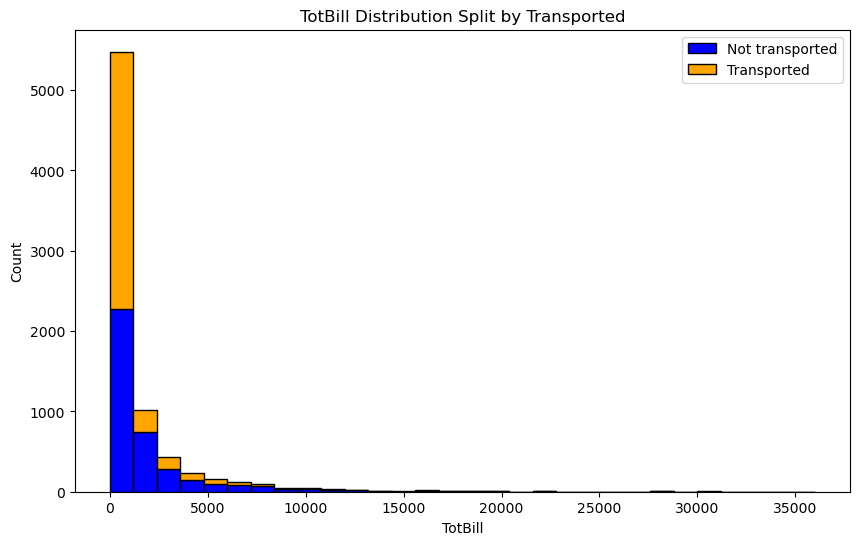

In [44]:
# Create a new column that contains the sum of the bills.
train_df["TotBill"] = train_df["RoomService"] + train_df["FoodCourt"] + train_df["ShoppingMall"] + train_df["Spa"] + train_df["VRDeck"]
distrib_split_by_transported(train_df, "TotBill")

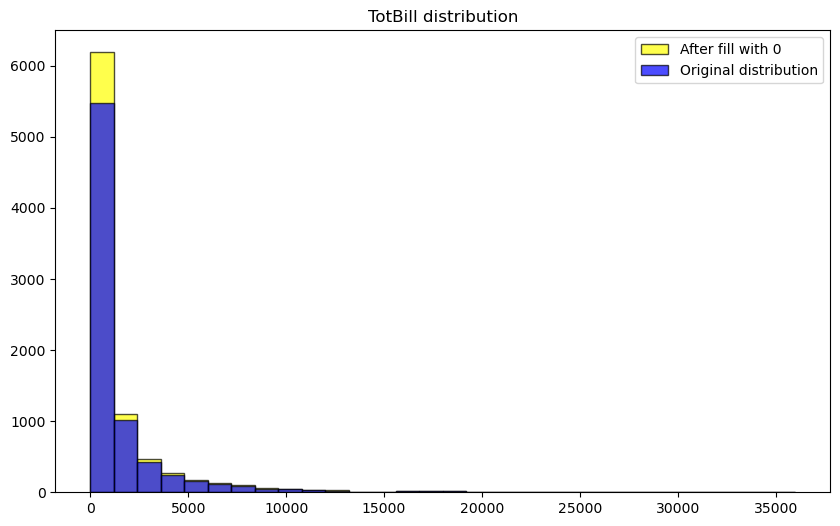

In [45]:
# Let's see how the distribution changes if we fill with 0's the missing data.
zero_fillna = (
    train_df["RoomService"].fillna(0) + 
    train_df["FoodCourt"].fillna(0) + 
    train_df["ShoppingMall"].fillna(0) + 
    train_df["Spa"].fillna(0) + 
    train_df["VRDeck"].fillna(0)
)

plt.figure(figsize=(10, 6))
plt.hist(zero_fillna.to_list(), bins=30, color='yellow', alpha=0.7, edgecolor='black', label="After fill with 0")
plt.hist(train_df["TotBill"].to_list(), bins=30, color='blue', alpha=0.7, edgecolor='black', label="Original distribution")
plt.title("TotBill distribution")
plt.legend()
plt.show()

In [46]:
# Let's replace the TotBill column with the zero_fillna.

# Train dataframe.
train_df["TotBill"] = zero_fillna

# Test dataframe.
test_df["TotBill"] = (
    test_df["RoomService"].fillna(0) + 
    test_df["FoodCourt"].fillna(0) + 
    test_df["ShoppingMall"].fillna(0) + 
    test_df["Spa"].fillna(0) + 
    test_df["VRDeck"].fillna(0)
)

### RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: manage missing values

In [47]:
# Train dataframe.
for name in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
    train_df[name] = train_df[name].fillna(0)

# Test dataframe.
for name in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
    test_df[name] = test_df[name].fillna(0)

### Categorize TotBill feature

TotBill
Low          3758
Mid          2819
High         1479
Very high     637
Name: count, dtype: int64


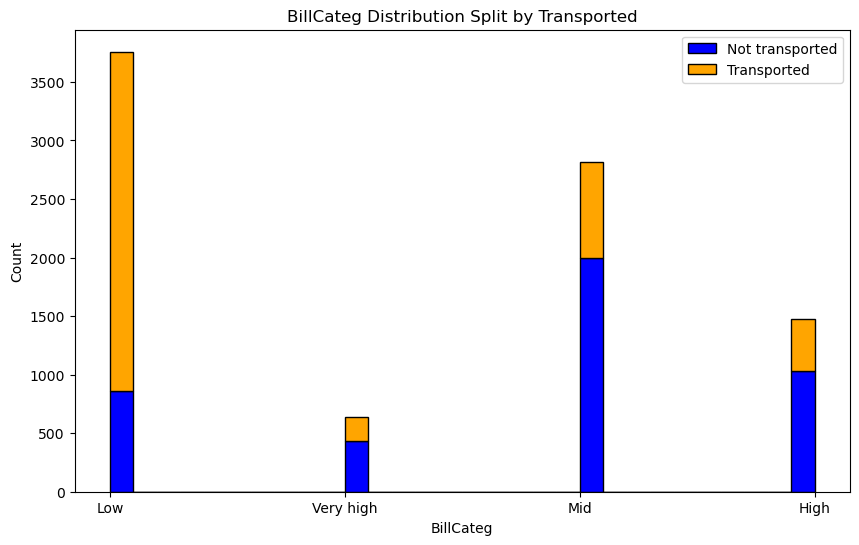

In [48]:
def categ_totbill(totbill):
    if totbill <= 500:
        return "Low"
    elif totbill <= 1500:
        return "Mid"
    elif totbill <= 5000:
        return "High"
    else:
        return "Very high"

# Train dataframe.
status_col = train_df["TotBill"].apply(categ_totbill)
print(status_col.value_counts())
train_df["BillCateg"] = status_col
distrib_split_by_transported(train_df, "BillCateg")

# Test dataframe.
test_df["BillCateg"] = test_df["TotBill"].apply(categ_totbill)

# Drop the TotBill column.
#train_df = train_df.drop(columns="TotBill", axis=1)
#test_df = test_df.drop(columns="TotBill", axis=1)

### New feature: Group

Extract the Group from the PassengerId column.

In [49]:
def get_group(Id):
    Id = Id.split("_")
    return Id[0]

# Train dataframe.
group_col = train_df["PassengerId"].apply(get_group)
print(group_col.value_counts())
train_df["Group"] = group_col
#distrib_split_by_transported(train_df, "Group")

# Train dataframe.
test_df["Group"] = test_df["PassengerId"].apply(get_group)

PassengerId
4256    8
5133    8
8956    8
8168    8
0984    8
       ..
3469    1
3468    1
3467    1
3465    1
3491    1
Name: count, Length: 6217, dtype: int64


### New feature: Deck

Cabin
F           2799
G           2559
E            876
B            779
C            747
D            478
A            256
FakeDeck     199
Name: count, dtype: int64


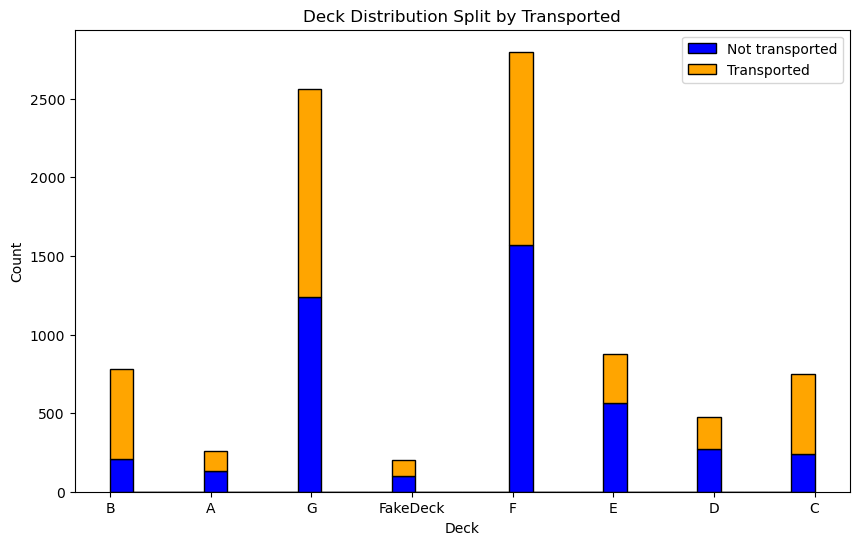

In [50]:
def get_deck(cabin):
    val = cabin.split("/")[0]
    if val == "T":
        val = "F"
    return val

# Train dataset.
deck_col = train_df["Cabin"].fillna("FakeDeck").apply(get_deck)
print(deck_col.value_counts())
train_df["Deck"] = deck_col
distrib_split_by_transported(train_df, "Deck")

# Test dataset.
test_df["Deck"] = test_df["Cabin"].fillna("FakeDeck").apply(get_deck)

### New feature: CabinNum

In [51]:
def get_cabinnum(cabin):
    if cabin == "FakeCabin":
        return -1
    return int(cabin.split("/")[1])

# Train dataframe.
cabinnum_col = train_df["Cabin"].fillna("FakeCabin").apply(get_cabinnum)
print(cabinnum_col.value_counts())
train_df["CabinNum"] = cabinnum_col

# Test dataframe.
test_df["CabinNum"] = test_df["Cabin"].fillna("FakeCabin").apply(get_cabinnum)

Cabin
-1       199
 82       28
 19       22
 86       22
 176      21
        ... 
 1863      1
 1864      1
 1865      1
 1761      1
 1866      1
Name: count, Length: 1818, dtype: int64


### New feature: CabinSide

Cabin
S    4377
P    4316
Name: count, dtype: int64


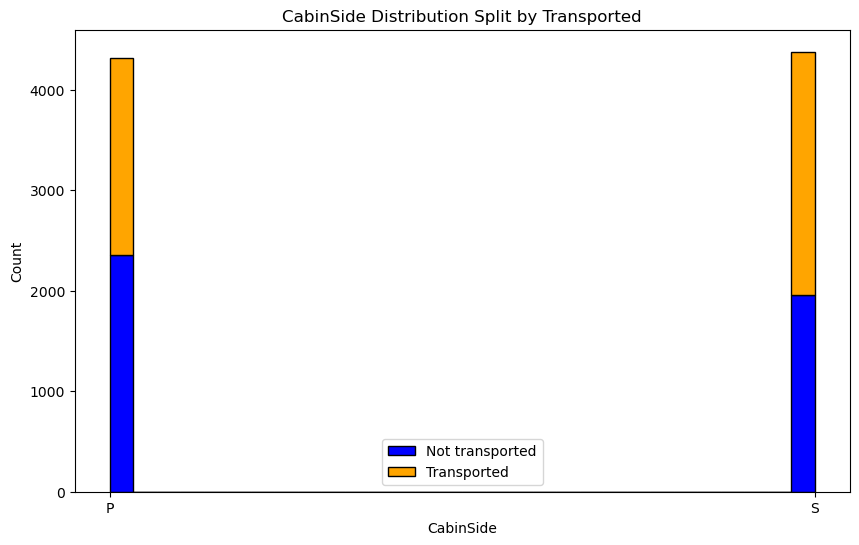

In [52]:
def get_cabinside(cabin):
    if cabin == "FakeCabin":
        return np.random.choice(["P", "S"])
    return cabin.split("/")[2]

# Train dataframe.
cabinside_col = train_df["Cabin"].fillna("FakeCabin").apply(get_cabinside)
print(cabinside_col.value_counts())
train_df["CabinSide"] = cabinside_col
distrib_split_by_transported(train_df, "CabinSide")

# Test dataframe.
test_df["CabinSide"] = test_df["Cabin"].fillna("FakeCabin").apply(get_cabinside)

### HomePlanet, manage missing values

In [53]:
print("Tot passenger with nan HomePlanet that are part of a group of size > 1:", train_df.groupby(["Group"]).filter(lambda x: len(x) > 1)["HomePlanet"].isna().sum())
print("Tot passenger with nan HomePlanet that are lonely in the group:", train_df.groupby(["Group"]).filter(lambda x: len(x) == 1)["HomePlanet"].isna().sum())
print()
print("Tot passenger travelling in a group larger than 1:", len(train_df.groupby(["Group"]).filter(lambda x: len(x) > 1).groupby("Group")))
print("Tot passenger travelling in a group larger that 1 that have same HomePlanet:", len(train_df.groupby(["Group", "HomePlanet"]).filter(lambda x: len(x) > 1).groupby("Group").size()))

Tot passenger with nan HomePlanet that are part of a group of size > 1: 92
Tot passenger with nan HomePlanet that are lonely in the group: 109

Tot passenger travelling in a group larger than 1: 1412
Tot passenger travelling in a group larger that 1 that have same HomePlanet: 1370


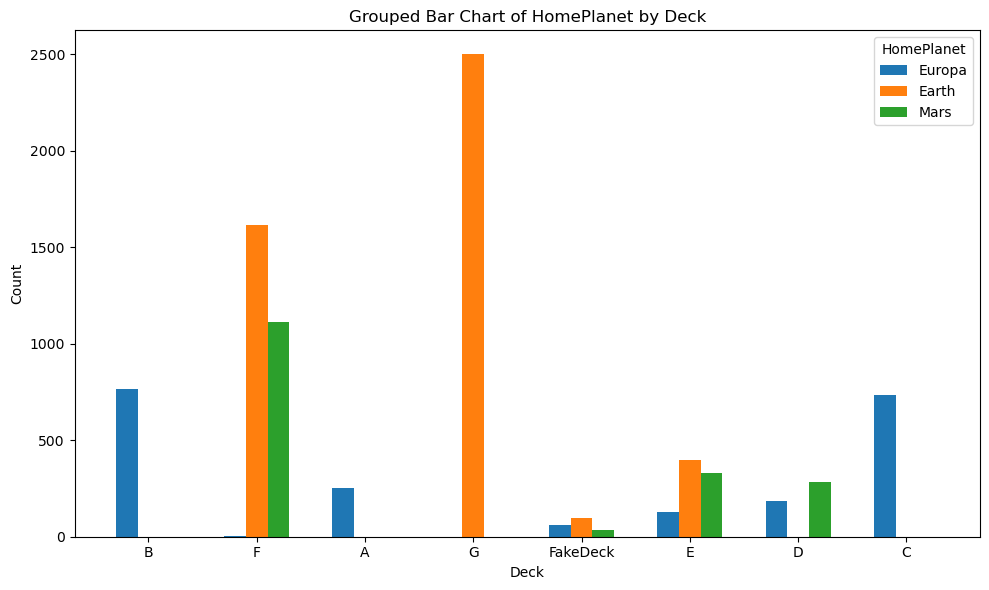

In [54]:
# Is there a relationship between Deck and HomePlanet?
deck_categ = train_df["Deck"].unique()
homep = train_df["HomePlanet"].dropna().unique()

counts = {deck: [len(train_df[(train_df["Deck"] == deck) & (train_df["HomePlanet"] == planet)]) for planet in homep] for deck in deck_categ}

bar_width = 0.2
x = np.arange(len(deck_categ))  # x positions for the groups.

# Plot bars for each class.
plt.figure(figsize=(10, 6))
for i, planet in enumerate(homep):
    plt.bar(x + i * bar_width, [counts[deck][i] for deck in deck_categ], width=bar_width, label=f"{planet}")

plt.xticks(x + bar_width, deck_categ)  # Center group labels.
plt.xlabel("Deck")
plt.ylabel("Count")
plt.title("Grouped Bar Chart of HomePlanet by Deck")
plt.legend(title="HomePlanet")

plt.tight_layout()
plt.show()

In [55]:
# We can try the following: consider the passenger that have a missing HomePlanet. If they are travelling in a group larger than one,
# then set missin HomePlanet to a value taken from one of the other member of the group.

group_sizes = train_df["Group"].map(train_df["Group"].value_counts())

def fill_home_planet(group):
    if group["HomePlanet"].isnull().any():
        non_null_planets = group["HomePlanet"].dropna()
        if not non_null_planets.empty:
            group["HomePlanet"] = group["HomePlanet"].fillna(non_null_planets.iloc[0])
    return group

# Train dataframe.
old_homeplanet_col = train_df["HomePlanet"].dropna()
train_df = train_df.groupby("Group", group_keys=False).apply(fill_home_planet)

# Test dataframe.
test_df = test_df.groupby("Group", group_keys=False).apply(fill_home_planet)

/tmp/ipykernel_14071/3714182657.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby("Group", group_keys=False).apply(fill_home_planet)
/tmp/ipykernel_14071/3714182657.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = test_df.groupby("Group", group_keys=False).apply(fill_home_planet)


In [56]:
# There are more missing values. Let's use the relation Deck-HomePlanet.
np.random.seed(12)

def fill_home_planet_2(row):
    if row["HomePlanet"] is not np.nan:
        return row
    elif row["Deck"] in ["A", "B", "C"]:
        row["HomePlanet"] = "Europa"
        return row
    elif row["Deck"] == "G":
        row["HomePlanet"] = "Earth"
        return row
    elif row["Deck"] == "F":
        row["HomePlanet"] = np.random.choice(["Earth", "Mars"])
        return row
    elif row["Deck"] == "D":
        row["HomePlanet"] = np.random.choice(["Europa", "Mars"])
        return row
    elif row["Deck"] == "E":
        row["HomePlanet"] = np.random.choice(["Europa", "Mars", "Earth"])
        return row
    elif row["Deck"] == "FakeDeck":
        row["HomePlanet"] = np.random.choice(["Europa", "Mars", "Earth"])
        return row
    else:
        row["HomePlanet"] = "Earth"
        return row

# Train dataframe.
train_df = train_df.apply(fill_home_planet_2, axis=1)

# Test dataframe (use the same probability used before)
test_df = test_df.apply(fill_home_planet_2, axis=1)

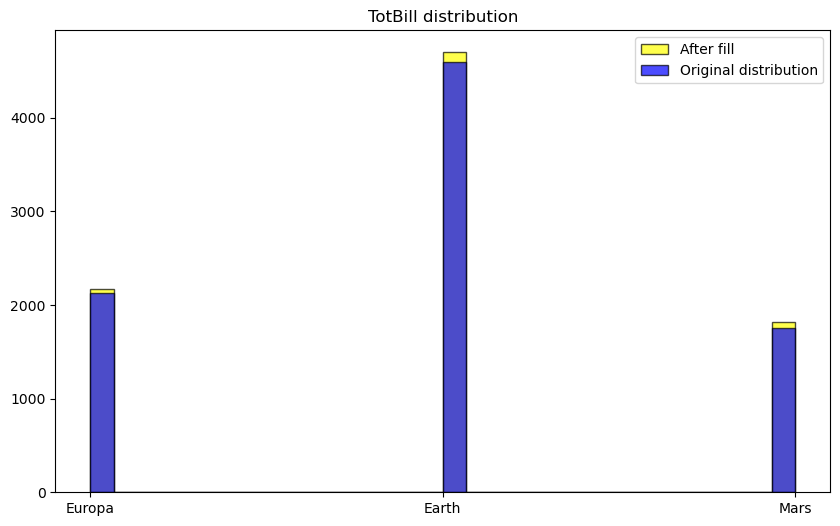

In [57]:
plt.figure(figsize=(10, 6))
plt.hist(train_df["HomePlanet"].to_list(), bins=30, color='yellow', alpha=0.7, edgecolor='black', label="After fill")
plt.hist(old_homeplanet_col.to_list(),bins=30, color='blue', alpha=0.7, edgecolor='black', label="Original distribution")
plt.title("TotBill distribution")
plt.legend()
plt.show()

### Destination, manage missing values

Let's use the same strategy used for the HomePlanet.

In [58]:
print("Tot passenger with nan Destination that are part of a group of size > 1:", train_df.groupby(["Group"]).filter(lambda x: len(x) > 1)["Destination"].isna().sum())
print("Tot passenger with nan Destination that are lonely in the group:", train_df.groupby(["Group"]).filter(lambda x: len(x) == 1)["Destination"].isna().sum())
print()
print("Tot passenger travelling in a group larger than 1:", len(train_df.groupby(["Group"]).filter(lambda x: len(x) > 1).groupby("Group")))
print("Tot passenger travelling in a group larger that 1 that have same Destination:", len(train_df.groupby(["Group", "Destination"]).filter(lambda x: len(x) > 1).groupby("Group").size()))

Tot passenger with nan Destination that are part of a group of size > 1: 79
Tot passenger with nan Destination that are lonely in the group: 103

Tot passenger travelling in a group larger than 1: 1412
Tot passenger travelling in a group larger that 1 that have same Destination: 1002


In this case $(1002/1412) \cdot 100 \approx 70\%$... so maybe there are better options.

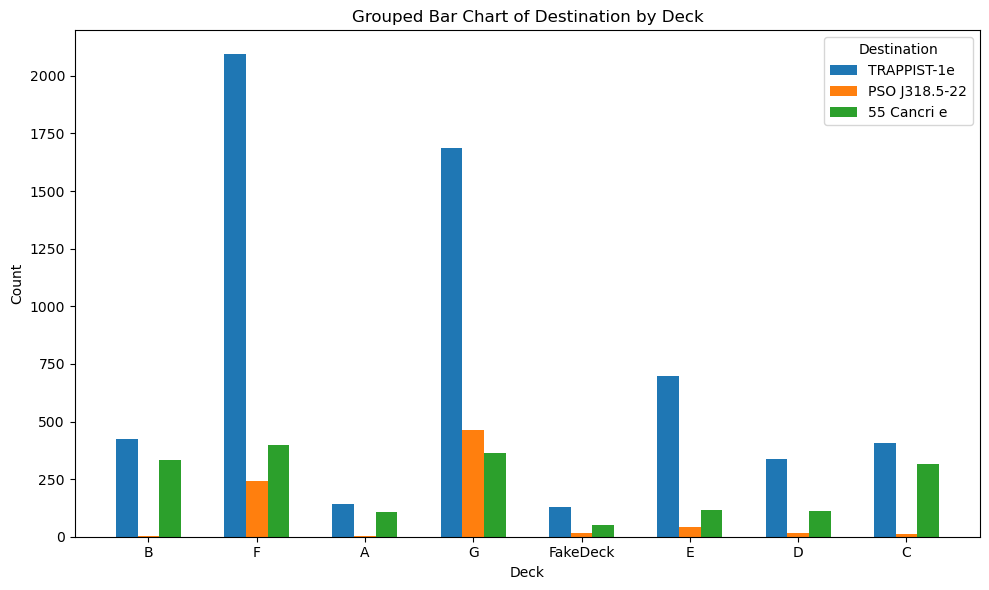

In [59]:
# Is there a relationship between Deck and Destination?
deck_categ = train_df["Deck"].unique()
homep = train_df["Destination"].dropna().unique()

counts = {deck: [len(train_df[(train_df["Deck"] == deck) & (train_df["Destination"] == planet)]) for planet in homep] for deck in deck_categ}

bar_width = 0.2
x = np.arange(len(deck_categ))  # x positions for the groups.

plt.figure(figsize=(10, 6))
for i, planet in enumerate(homep):
    plt.bar(x + i * bar_width, [counts[deck][i] for deck in deck_categ], width=bar_width, label=f"{planet}")

plt.xticks(x + bar_width, deck_categ)  # Center group labels.
plt.xlabel("Deck")
plt.ylabel("Count")
plt.title("Grouped Bar Chart of Destination by Deck")
plt.legend(title="Destination")

plt.tight_layout()
plt.show()

Mmh... not as good as for HomePlanet.
Since the majority of the passengers have TRAPPIST-1e as destination, we fill all the missing values with this destination.

In [60]:
# Train dataframe.
train_df["Destination"] = train_df["Destination"].fillna("TRAPPIST-1e")
# Test dataframe.
test_df["Destination"] = test_df["Destination"].fillna("TRAPPIST-1e")

### VIP, manage missing values

Just fill the missing values with False since there are very few VIPs.

In [61]:
# Train dataframe.
train_df["VIP"] = train_df["VIP"].fillna(0)
# Test dataframe.
test_df["VIP"] = test_df["VIP"].fillna(0)

### Age, manage missing values
Up to this point there are two columns that have missing values: Age and CryoSleep.

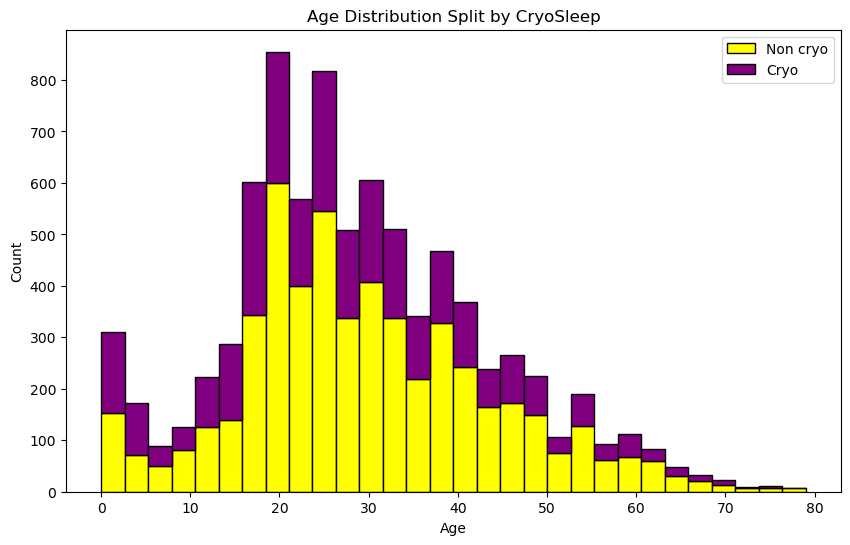

In [62]:
# Is there a relation beween Age and CryoSleep?
non_cryo = train_df[train_df["CryoSleep"] == 0]["Age"].dropna()
cryo = train_df[train_df["CryoSleep"] == 1]["Age"].dropna()

# Create a stacked histogram
plt.figure(figsize=(10, 6))
plt.hist([non_cryo, cryo], bins=30, stacked=True, color=['yellow', 'purple'], label=['Non cryo', "Cryo"], edgecolor='black')

# Add labels and title
plt.xlabel("Age")
plt.ylabel("Count")
plt.title(f"{"Age"} Distribution Split by CryoSleep")
plt.legend()
plt.show()

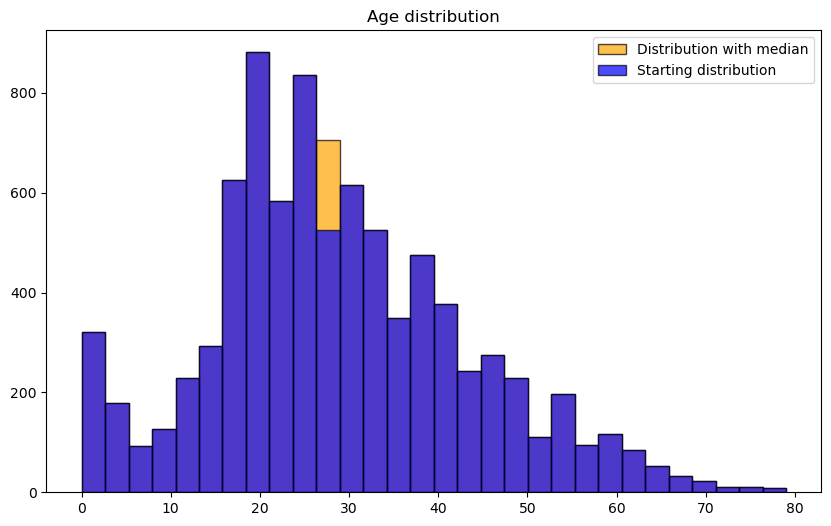

In [63]:
# Try with the median.
median_age_col = train_df['Age'].fillna(train_df['Age'].median())
# Print the distribution.
plt.figure(figsize=(10, 6))
plt.hist(median_age_col.tolist(), bins=30, color='orange', alpha=0.7, edgecolor='black', label="Distribution with median")
plt.hist(train_df["Age"].dropna().tolist(), bins=30, color='blue', alpha=0.7, edgecolor='black', label="Starting distribution")
plt.title("Age distribution")
plt.legend()
plt.show()

In [64]:
# Train dataframe.
train_df["Age"] = median_age_col
# Test dataframe.
test_df["Age"] = test_df["Age"].fillna(test_df["Age"].median())

### CryoSleep, manage missing values

Since passengers in CryoSleep are confinated in their cabin they must have TotBill = 0.

In [65]:
# How many passenger in CryoSleep have a TotBill equal to zero?
print("Tot passenger in CryoSleep:", len(train_df[train_df["CryoSleep"] == 1]))
print("Tot passenger in CryoSleep with TotBill = 0:", len(train_df[(train_df["TotBill"] == 0) & (train_df["CryoSleep"] == 1)]))
print("Tot passenger in with TotBill = 0:", len(train_df[train_df["TotBill"] == 0]))

Tot passenger in CryoSleep: 3037
Tot passenger in CryoSleep with TotBill = 0: 3037
Tot passenger in with TotBill = 0: 3653


$3037 / 3653 \approx 83\%$ of the passenger with TotBill = 0 are in CryoSleep.

In [66]:
# Train dataframe.
train_df.loc[(train_df["CryoSleep"].isna()) & (train_df["TotBill"] != 0), "CryoSleep"] = 0

# Test dataframe.
test_df.loc[(test_df["CryoSleep"].isna()) & (test_df["TotBill"] != 0), "CryoSleep"] = 0

     HomePlanet    Destination   Age    VIP  CabinNum CabinSide
0        Europa    TRAPPIST-1e  39.0  False         0         P
7         Earth    TRAPPIST-1e  28.0  False         0         S
9        Europa    55 Cancri e  14.0  False         1         P
10       Europa    TRAPPIST-1e  34.0  False         1         P
18         Mars    TRAPPIST-1e  45.0  False         5         P
...         ...            ...   ...    ...       ...       ...
8680      Earth    TRAPPIST-1e  31.0  False      1505         P
8681      Earth    55 Cancri e  33.0  False      1497         S
8684      Earth    TRAPPIST-1e  23.0  False      1508         P
8685     Europa    TRAPPIST-1e   0.0  False        97         P
8689      Earth  PSO J318.5-22  18.0  False      1499         S

[3381 rows x 6 columns]
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Optimal param: {'bootstrap': False, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, '

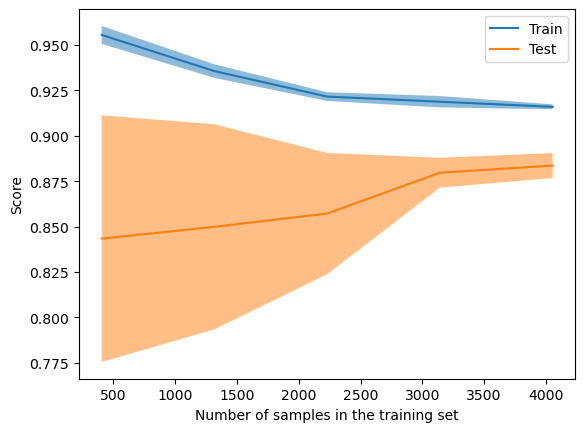

In [67]:
to_drop = ["Deck", "PassengerId", "Transported", "CryoSleep", "TotBill", "BillCateg", "Cabin", "Group", "Name", "ShoppingMall", "Spa", "RoomService", "FoodCourt", "VRDeck"]
X_cryo_train = train_df[train_df["TotBill"] == 0].dropna().drop(columns=to_drop, axis=1)
print(X_cryo_train)
X_cryo_train = X_cryo_train.values
X_cryo_train = np.vstack((X_cryo_train, test_df[test_df["TotBill"] == 0].dropna().drop(columns=[v for v in to_drop if v != "Transported"], axis=1).values))


Y_cryo_train = train_df[train_df["TotBill"] == 0].dropna()["CryoSleep"]
Y_cryo_train = Y_cryo_train.values
Y_cryo_train = np.append(Y_cryo_train, test_df[test_df["TotBill"] == 0].dropna()["CryoSleep"].to_list())

# Encode.
to_encode = [0, 1, 5]
enc = OrdinalEncoder(dtype=int)
X_cryo_train[:, to_encode] = enc.fit_transform(X_cryo_train[:, to_encode])

lbenc = LabelEncoder()
Y_cryo_train = lbenc.fit_transform(Y_cryo_train.ravel())

param_grid = {
    "n_estimators": [100],
    "max_depth": [None, 2, 3, 4, 5, 6, 7, 8], 
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3],
    "max_features": ["sqrt"],
    "bootstrap":[False],
    "n_jobs": [-1],
    "random_state": [12]
}

dt_gs = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, verbose=1)
dt_gs.fit(X_cryo_train, Y_cryo_train)
print("Optimal param:", dt_gs.best_params_)
LearningCurveDisplay.from_estimator(dt_gs.best_estimator_, X_cryo_train, Y_cryo_train)

X_cryo_test = test_df[test_df["TotBill"] == 0].dropna().drop(columns=[v for v in to_drop if v != "Transported"], axis=1)
Y_cryo_test = test_df[test_df["TotBill"] == 0].dropna()["CryoSleep"]
print(X_cryo_test)
X_cryo_test = X_cryo_test.values
Y_cryo_test = Y_cryo_test.values

X_cryo_test[:, to_encode] = enc.transform(X_cryo_test[:, to_encode])

Y_cryo_test = lbenc.transform(Y_cryo_test.ravel())

print("Train score:", dt_gs.best_estimator_.score(X_cryo_train, Y_cryo_train))
print("Test score:", dt_gs.best_estimator_.score(X_cryo_test, Y_cryo_test))

#from sklearn import tree
#features_names = ["HomePlanet", "Destination", "Age", "VIP", "CabinNum", "CabinSide"]
#plt.figure()
#tree.plot_tree(decision_tree = dt_gs.best_estimator_,
#               feature_names=features_names, 
#               filled=True)
#plt.savefig('tree.pdf')
#plt.show()

In [30]:
# Train dataframe.
to_predict = train_df[train_df["CryoSleep"].isna()].drop(columns=to_drop, axis=1)
print(to_predict)
to_predict = to_predict.values

# Encode.
to_predict[:, to_encode] = enc.transform(to_predict[:, to_encode])

# Predict.
missing_cryo = dt_gs.best_estimator_.predict(to_predict)
train_df.loc[train_df["CryoSleep"].isna(), "CryoSleep"] = missing_cryo


# Test dataframe.
to_predict = test_df[test_df["CryoSleep"].isna()].drop(columns=[v for v in to_drop if v != "Transported"], axis=1)
to_predict = to_predict.values

# Encode.
to_predict[:, to_encode] = enc.transform(to_predict[:, to_encode])

# Predict.
missing_cryo = dt_gs.best_estimator_.predict(to_predict)
test_df.loc[test_df["CryoSleep"].isna(), "CryoSleep"] = missing_cryo

     HomePlanet    Destination   Age    VIP  CabinNum CabinSide
92        Earth    TRAPPIST-1e   2.0  False        12         P
111        Mars    TRAPPIST-1e  26.0  False        24         P
175       Earth  PSO J318.5-22  52.0  False        30         P
266      Europa    TRAPPIST-1e  43.0  False         7         S
392      Europa    55 Cancri e  27.0  False        20         P
...         ...            ...   ...    ...       ...       ...
8501      Earth    TRAPPIST-1e  32.0  False      1461         S
8612      Earth  PSO J318.5-22  35.0  False      1483         S
8620     Europa    55 Cancri e  44.0  False       308         P
8651      Earth    TRAPPIST-1e   8.0  False      1498         P
8664      Earth    TRAPPIST-1e  32.0  False      1490         S

[98 rows x 6 columns]


### Encode Age feature

In [31]:
#def categ_age(age):
#    if age <= 12:
#        return "Child"
#    elif age <= 20:
#        return "Teen"
#    elif age <= 30:
#        return "Young adult"
#    elif age <= 55:
#        return "Adult"
#    else:
#        return "Elderly"
#
## Train dataframe.
#new_age_col = train_df["Age"].apply(categ_age)
#print(new_age_col.value_counts())
#train_df["Age"] = new_age_col
#
## Test dataframe.
#test_df["Age"] = test_df["Age"].apply(categ_age)

### Drop some features

In [32]:
train_df = train_df.drop(columns=["PassengerId", "Cabin", "Name", "Group", "TotBill"], axis=1)
print(train_df.isna().sum())
print("\n\n")
test_df = test_df.drop(columns=["Cabin", "Name", "Group", "TotBill"], axis=1)
print(test_df.isna().sum())

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
BillCateg       0
Deck            0
CabinNum        0
CabinSide       0
dtype: int64



PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
BillCateg       0
Deck            0
CabinNum        0
CabinSide       0
dtype: int64


## Encode categorical features

In [33]:
X_train = train_df.dropna().drop(columns="Transported")
X_test = test_df.dropna()
Y_train = train_df.dropna()["Transported"]

print("Tot number of samples in train set:", X_train.shape[0])
print("Tot number of samples in test set:", X_test.shape[0])
features_names = list(X_train.columns)
print("Features names:", features_names)

X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values

Tot number of samples in train set: 8693
Tot number of samples in test set: 4277
Features names: ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'BillCateg', 'Deck', 'CabinNum', 'CabinSide']


In [34]:
# Print the data type of each column.
for index_col, name_col in zip(range(X_train.shape[1]), features_names):
    print(f"Column {name_col} (index: {index_col}) -- data type: {type(X_train[0, index_col])}")

Column HomePlanet (index: 0) -- data type: <class 'str'>
Column CryoSleep (index: 1) -- data type: <class 'bool'>
Column Destination (index: 2) -- data type: <class 'str'>
Column Age (index: 3) -- data type: <class 'float'>
Column VIP (index: 4) -- data type: <class 'bool'>
Column RoomService (index: 5) -- data type: <class 'float'>
Column FoodCourt (index: 6) -- data type: <class 'float'>
Column ShoppingMall (index: 7) -- data type: <class 'float'>
Column Spa (index: 8) -- data type: <class 'float'>
Column VRDeck (index: 9) -- data type: <class 'float'>
Column BillCateg (index: 10) -- data type: <class 'str'>
Column Deck (index: 11) -- data type: <class 'str'>
Column CabinNum (index: 12) -- data type: <class 'int'>
Column CabinSide (index: 13) -- data type: <class 'str'>


In [35]:
# Encode the categorical variables.
to_encode = np.array([0, 2, 10, 11, 13])

enc = OrdinalEncoder()

enc.fit(X_train[:, to_encode])
X_train[:, to_encode] = enc.transform(X_train[:, to_encode])
X_test[:, to_encode+1] = enc.transform(X_test[:, to_encode+1])

# Print the data type of each column.
for index_col, name_col in zip(range(X_train.shape[1]), features_names):
    print(f"Column {name_col} (index: {index_col}) -- data type: {type(X_train[0, index_col])}")

Column HomePlanet (index: 0) -- data type: <class 'float'>
Column CryoSleep (index: 1) -- data type: <class 'bool'>
Column Destination (index: 2) -- data type: <class 'float'>
Column Age (index: 3) -- data type: <class 'float'>
Column VIP (index: 4) -- data type: <class 'bool'>
Column RoomService (index: 5) -- data type: <class 'float'>
Column FoodCourt (index: 6) -- data type: <class 'float'>
Column ShoppingMall (index: 7) -- data type: <class 'float'>
Column Spa (index: 8) -- data type: <class 'float'>
Column VRDeck (index: 9) -- data type: <class 'float'>
Column BillCateg (index: 10) -- data type: <class 'float'>
Column Deck (index: 11) -- data type: <class 'float'>
Column CabinNum (index: 12) -- data type: <class 'int'>
Column CabinSide (index: 13) -- data type: <class 'float'>


## Standardize data

In [36]:
# Standardize age and fare columns.
to_scale = np.array([3, 5, 6, 7, 8, 9, 12])

# Create a copy for each set.
X_train_scaled = np.copy(X_train)
X_test_scaled = np.copy(X_test)

# Scale data.
scaler = StandardScaler().fit(X_train[:, to_scale])
X_train_scaled[:, to_scale] = scaler.transform(X_train[:, to_scale])
X_test_scaled[:, to_scale+1] = scaler.transform(X_test[:, to_scale+1])

## Random Forest

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Optimal param: {'bootstrap': False, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150, 'n_jobs': -1, 'random_state': 12}


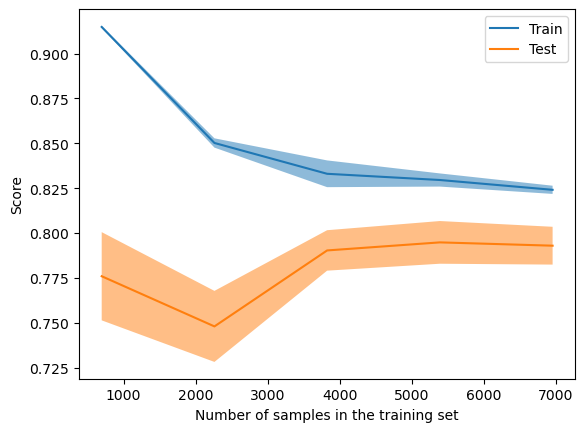

In [37]:
#param_grid = {
#    "n_estimators": [100, 150],
#    "max_depth": [None, 5, 7, 10], 
#    "min_samples_split": [2, 3, 4],
#    "min_samples_leaf": [1, 2, 3],
#    "max_features": ["sqrt", "log2", None],
#    "bootstrap":[False],
#    "n_jobs": [-1],
#    "random_state": [12]
#}

param_grid = {
    "n_estimators": [150],
    "max_depth": [5, 7, 10], 
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3],
    "max_features": ["sqrt"],
    "bootstrap":[False],
    "n_jobs": [-1],
    "random_state": [12]
}

rf_gs = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, verbose=1)
rf_gs.fit(X_train_scaled, Y_train)
print("Optimal param:", rf_gs.best_params_)
LearningCurveDisplay.from_estimator(rf_gs.best_estimator_, X_train_scaled, Y_train)

## Create submission

In [38]:
# Compute predictions.
predictions = rf_gs.best_estimator_.predict(X_test_scaled[:, 1:])

# Save predictions.
output = pd.DataFrame({'PassengerId': test_df["PassengerId"], 'Transported': predictions}) 
output.to_csv('../outputdata/submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
